# LAB 4 Information Security

In [91]:
import random
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np


## TASK 1

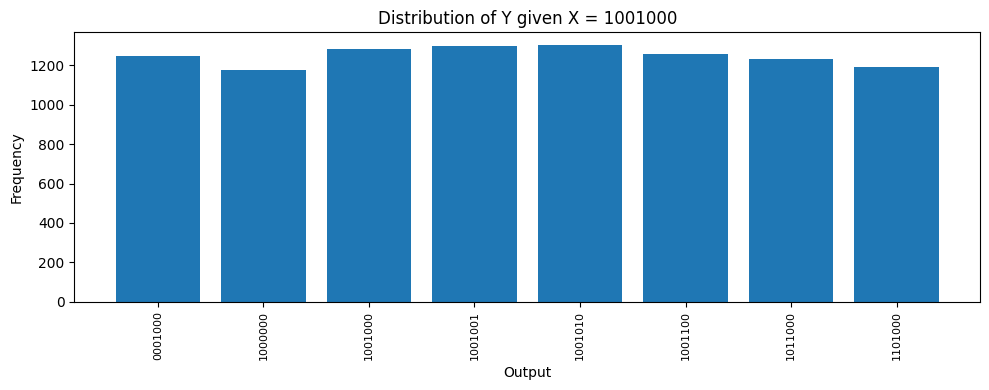

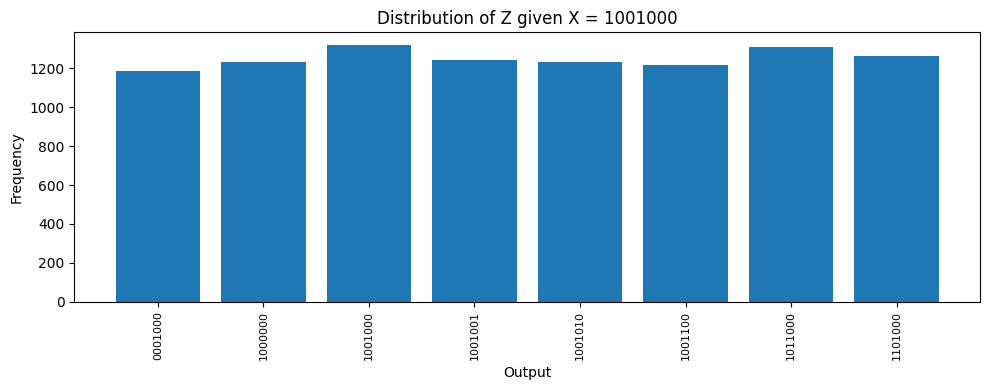

In [92]:
def generate_error_set(x, max_errors=1):
    """
    Generate every binary vector with Hamming distance ≤ max_errors from x.
    """
    n = len(x)
    neighbors = set()
    x_int = int(x, 2)

    # No error
    neighbors.add(x_int)

    for num_errors in range(1, max_errors + 1):
        for bit_positions in itertools.combinations(range(n), num_errors):
            error_mask = sum(1 << pos for pos in bit_positions)
            neighbors.add(x_int ^ error_mask)

    return [format(v, f"0{n}b") for v in neighbors]


def wiretap_channel(x):
    """
    Simulate wiretap channel:
    - y: output of the legitimate receiver (max 1 error)
    - z: output of the eavesdropper (max 1 error)
    """
    Ty = generate_error_set(x)
    Tz = generate_error_set(x)
    y = random.choice(Ty)
    z = random.choice(Tz)
    return y, z

def run_experiment(x, num_samples=10000):
    y_samples = []
    z_samples = []

    for _ in range(num_samples):
        y, z = wiretap_channel(x)
        y_samples.append(y)
        z_samples.append(z)

    return y_samples, z_samples

def plot_distribution(samples, title):
    counter = Counter(samples)
    labels, counts = zip(*sorted(counter.items()))
    plt.figure(figsize=(10, 4))
    plt.bar(labels, counts)
    plt.xticks(rotation=90, fontsize=8)
    plt.title(title)
    plt.xlabel("Output")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

x_input = "1001000"
y_samples, z_samples = run_experiment(x_input, 10000)
plot_distribution(y_samples, "Distribution of Y given X = 1001000")
plot_distribution(z_samples, "Distribution of Z given X = 1001000")


In [93]:

# Matrix H (3x7) for Hamming code (7,4)
H = np.array([
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 1]
], dtype=int)

input_arr = np.array([1,0,0,1,0,0,0])

def syndrome(x):
    
    s = (H @ x) % 2
    return s

print(syndrome(input_arr))


[1 1 1]


## TASK 2 E 3

In [94]:
def recover(mess, syn):
    """
    Hamming (7,4) single-error decoder.
    If mess’s syndrome already equals syn, returns mess.
    Otherwise, flips the one bit whose column in H equals the difference.
    Returns corrected 7-bit array or None.
    """
    syn_received = syndrome(mess)
    if np.array_equal(syn_received, syn):
        return mess.copy()
    diff = (syn_received + syn) % 2
    for i in range(H.shape[1]):
        if np.array_equal(H[:, i], diff):
            corrected = mess.copy()
            corrected[i] ^= 1
            return corrected
    return None

X_str = "1001000"
X = np.array([int(b) for b in X_str], dtype=int)
c = syndrome(X)

# Simulate wiretap channel for Bob and Eve
Y_str, Z_str = wiretap_channel(X_str)
Y = np.array([int(b) for b in Y_str], dtype=int)

# Bob and Eve both attempt to recover X
X_hat_bob = recover(Y, c)
X_hat_eve = recover(Y, c)

print("---- Forward Reconciliation ----")
print(f"X original:          {X_str}")
print(f"Y received by Bob:   {Y_str}")
print(f"Z received by Eve:   {Z_str}")
print("Bob recovers X as:   ",
      "".join(str(bit) for bit in X_hat_bob) if X_hat_bob is not None else "Decoding failed")
print("Eve recovers X as:   ",
      "".join(str(bit) for bit in X_hat_eve) if X_hat_eve is not None else "Decoding failed")

# Reverse Reconciliation (Bob -> Alice)
# Step 1: Alice sends X, Bob receives Y
Y_str, _ = wiretap_channel(X_str)
Y = np.array([int(b) for b in Y_str], dtype=int)
c_y = syndrome(Y)

# Step 2: Alice receives a possibly corrupted version of X
Xp_str, _ = wiretap_channel(X_str)
Xp = np.array([int(b) for b in Xp_str], dtype=int)

# Alice attempts to recover Y
Y_hat_alice = recover(Xp, c_y)
# Eve also knows Xp and c_y and tries the same
Y_hat_eve = recover(Xp, c_y)

print("\n---- Reverse Reconciliation (Single Trial) ----")
print(f"X original:            {X_str}")
print(f"Y received by Bob:     {Y_str}")
print(f"X' received by Alice:  {Xp_str}")
print("Alice recovers Y as:   ",
      "".join(str(bit) for bit in Y_hat_alice) if Y_hat_alice is not None else "Decoding failed")
print("Eve recovers Y as:     ",
      "".join(str(bit) for bit in Y_hat_eve) if Y_hat_eve is not None else "Decoding failed")

# Statistical test: Eve's success rate in Reverse Reconciliation over many trials
num_trials = 10000
eve_success = 0

for _ in range(num_trials):
    # Bob receives Y from X
    Y_str, _ = wiretap_channel(X_str)
    Y = np.array([int(b) for b in Y_str], dtype=int)
    c_y = syndrome(Y)

    # Alice receives X' from X
    Xp_str, _ = wiretap_channel(X_str)
    Xp = np.array([int(b) for b in Xp_str], dtype=int)

    # Eve tries to recover Y
    Y_hat_eve = recover(Xp, c_y)
    if Y_hat_eve is not None and "".join(str(b) for b in Y_hat_eve) == Y_str:
        eve_success += 1

print(f"\nEve's success rate in Reverse Reconciliation over {num_trials} trials: {eve_success/num_trials:.4f}")



---- Forward Reconciliation ----
X original:          1001000
Y received by Bob:   1001000
Z received by Eve:   1001001
Bob recovers X as:    1001000
Eve recovers X as:    1001000

---- Reverse Reconciliation (Single Trial) ----
X original:            1001000
Y received by Bob:     1001000
X' received by Alice:  1001100
Alice recovers Y as:    1001000
Eve recovers Y as:      1001000

Eve's success rate in Reverse Reconciliation over 10000 trials: 0.3460


## TASK 4

In [95]:

# Matrix A (4×7) from the PDF
A = np.array([
    [1, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 0]
], dtype=int)

def deterministic_privacy_amplification(W):
    """
    Given a length-7 numpy array W (0/1), return the length-4 array y' = A·W (mod 2).
    """
    return (A @ W) % 2

num_trials = 10000
freq_counts = Counter()

for _ in range(num_trials):
    # 1) Pick X uniformly at random from {0,1}^7
    X_int = random.getrandbits(7)
    X_str = format(X_int, "07b")
    X = np.array([int(b) for b in X_str], dtype=int)

    # 2) Compute c = H·X mod 2
    c = syndrome(X)

    # 3) Simulate wiretap channel from X to Bob (Bob sees Y, but will recover X)
    Y_str, _ = wiretap_channel(X_str)
    Y = np.array([int(b) for b in Y_str], dtype=int)
    # Bob recovers X using (Y, c)
    X_hat_bob = recover(Y, c)
    # (We know recover(Y,c) must equal X because Hamming corrects ≤1 error)

    # Now Alice and Bob share the exact same W = X
    W = X_hat_bob

    # 4) Task 4: apply A to get 4-bit y'
    y_prime = deterministic_privacy_amplification(W)
    y_prime_str = "".join(str(bit) for bit in y_prime)
    freq_counts[y_prime_str] += 1

# Print empirical frequencies of all 16 possible 4-bit outputs
print("\nDeterministic Privacy Amplification Frequencies (forward mode):")
for w4 in sorted(freq_counts):
    print(f"{w4}: {freq_counts[w4]/num_trials:.4f}")

# Each printed frequency should be close to 1/16 ≈ 0.0625. YES!


Deterministic Privacy Amplification Frequencies (forward mode):
0000: 0.0569
0001: 0.0618
0010: 0.0614
0011: 0.0627
0100: 0.0612
0101: 0.0627
0110: 0.0632
0111: 0.0657
1000: 0.0612
1001: 0.0607
1010: 0.0639
1011: 0.0631
1100: 0.0651
1101: 0.0660
1110: 0.0592
1111: 0.0652


## TASK 5

In [96]:
import pandas as pd

def syndrome(x_vec):
    """
    Compute syndrome H·x_vec mod 2.
    x_vec: length-7 numpy array of 0/1
    Returns length-3 numpy array.
    """
    return (H @ x_vec) % 2

def deterministic_privacy_amplification(W):
    """
    Given a length-7 numpy array W (0/1), return the length-4 array y' = A·W (mod 2).
    """
    return (A @ W) % 2

def universal_hash(y_prime, ell):
    """
    Generate a random ℓ×4 binary matrix M and compute k = M · y_prime (mod 2).
    Returns (k_array, M).
    """
    M = np.random.randint(0, 2, size=(ell, 4), dtype=int)
    k = (M @ y_prime) % 2
    return k, M

def empirical_entropy(freq_dict, total):
    """
    Compute empirical Shannon entropy H = - sum p(x) log2 p(x)
    from a frequency dictionary {value: count}.
    """
    H_val = 0.0
    for count in freq_dict.values():
        p = count / total
        H_val -= p * np.log2(p)
    return H_val

# Main simulation for Task 5
num_trials = 10000

results = {}  # will store results for each ell

for ell in [1, 2, 3]:
    freq_k = Counter()
    freq_zc = Counter()
    freq_kzc = Counter()
    total_success = 0

    for _ in range(num_trials):
        # 1) Pick X uniformly at random from {0,1}^7
        X_int = random.getrandbits(7)
        X_str = format(X_int, "07b")
        X = np.array([int(b) for b in X_str], dtype=int)

        # 2) Forward reconciliation: compute c = H·X and simulate Bob's Y
        c = syndrome(X)
        Y_str, Z_str = wiretap_channel(X_str)
        Y = np.array([int(b) for b in Y_str], dtype=int)
        Z = np.array([int(b) for b in Z_str], dtype=int)

        # 3) Bob recovers X using (Y, c)
        X_hat_bob = recover(Y, c)
        if X_hat_bob is None:
            # If Bob failed (unlikely, Hamming corrects ≤1 error), skip
            continue

        # 4) Both Alice and Bob share W = X_hat_bob = X
        W = X_hat_bob

        # 5) Deterministic privacy amplification: get y' = A·W
        y_prime = deterministic_privacy_amplification(W)

        # 6) Generate a new random hash M for this block, compute k
        k_array, M = universal_hash(y_prime, ell)
        k_str = "".join(str(bit) for bit in k_array)

        # 7) Record frequencies
        zc_str = Z_str + "|" + "".join(str(bit) for bit in c)  # joint z,c string
        kzc_str = k_str + "|" + zc_str

        freq_k[k_str] += 1
        freq_zc[zc_str] += 1
        freq_kzc[kzc_str] += 1
        total_success += 1

    # Compute empirical marginal entropies
    H_k = empirical_entropy(freq_k, total_success)
    H_zc = empirical_entropy(freq_zc, total_success)
    H_kzc = empirical_entropy(freq_kzc, total_success)

    # Compute mutual information I(k; z,c) = H(k) + H(z,c) - H(k,z,c)
    I_k_zc = H_k + H_zc - H_kzc

    results[ell] = {
        "H(k)": H_k,
        "H(z,c)": H_zc,
        "H(k,z,c)": H_kzc,
        "I(k;z,c)": I_k_zc,
        "Total Trials": total_success
    }

# Display results
df = pd.DataFrame(results).T
df.index.name = "ell"
print("\nTask 5 Results (empirical entropies and mutual information):")
print(df)


Task 5 Results (empirical entropies and mutual information):
         H(k)    H(z,c)   H(k,z,c)  I(k;z,c)  Total Trials
ell                                                       
1    0.998108  9.920476  10.779761  0.138823       10000.0
2    1.990457  9.922915  11.554732  0.358640       10000.0
3    2.982668  9.922540  12.158880  0.746328       10000.0


## TASK 6

In [97]:
# 1) Standard BSC for 7-bit strings
def bsc_channel(x_str, p):
    """
    Binary Symmetric Channel on a 7-bit string x_str.
    Each bit flips with probability p independently.
    Returns a new 7-bit string.
    """
    out = []
    for bit in x_str:
        if random.random() < p:
            out.append('1' if bit == '0' else '0')
        else:
            out.append(bit)
    return "".join(out)

def wiretap_bsc(x_str, eps, delta):
    """
    Return (y, z) where
      y = bsc_channel(x_str, eps)  (Bob's copy),
      z = bsc_channel(x_str, delta) (Eve's copy).
    """
    y = bsc_channel(x_str, eps)
    z = bsc_channel(x_str, delta)
    return y, z

# 2) Forward‐reconciliation under Wiretap‐BSC
def forward_bsc_experiment(eps, delta, num_blocks=10000):
    """
    Simulate forward reconciliation over 'num_blocks' 7-bit blocks
    under BSC(eps) to Bob and BSC(delta) to Eve.
    Returns (bob_error_rate, eve_success_rate).
    """
    bob_errors = 0
    eve_success = 0

    for _ in range(num_blocks):
        # Pick X uniformly from {0,1}^7
        X_int = random.getrandbits(7)
        X_str = format(X_int, "07b")
        X = np.array([int(b) for b in X_str], dtype=int)

        # Compute c = H·X mod 2
        c = syndrome(X)

        # Send X through BSC(eps) to Bob and BSC(delta) to Eve
        Y_str, Z_str = wiretap_bsc(X_str, eps, delta)
        Y = np.array([int(b) for b in Y_str], dtype=int)

        # Bob recovers X from (Y, c)
        X_hat_bob = recover(Y, c)
        if X_hat_bob is None or not np.array_equal(X_hat_bob, X):
            bob_errors += 1

        # Eve attempts the same recovery on (Y, c)
        X_hat_eve = recover(Y, c)
        if X_hat_eve is not None and np.array_equal(X_hat_eve, X):
            eve_success += 1

    bob_error_rate = bob_errors / num_blocks
    eve_success_rate = eve_success / num_blocks
    return bob_error_rate, eve_success_rate

# 3) Reverse‐reconciliation under Wiretap‐BSC
def reverse_bsc_experiment(eps, delta, num_blocks=10000):
    """
    Simulate reverse reconciliation over 'num_blocks' 7-bit blocks
    under BSC(eps) to Bob and Alice, BSC(delta) to Eve.
    Returns (alice_error_rate, eve_success_rate).
    """
    alice_errors = 0
    eve_success = 0

    for _ in range(num_blocks):
        # Pick X uniformly from {0,1}^7
        X_int = random.getrandbits(7)
        X_str = format(X_int, "07b")
        X = np.array([int(b) for b in X_str], dtype=int)

        # Bob receives Y = BSC(eps)(X) and computes c_y = syndrome(Y)
        Y_str = bsc_channel(X_str, eps)
        Y = np.array([int(b) for b in Y_str], dtype=int)
        c_y = syndrome(Y)

        # Alice receives X' = BSC(eps)(X)
        Xp_str = bsc_channel(X_str, eps)
        Xp = np.array([int(b) for b in Xp_str], dtype=int)

        # Alice recovers Y from (X', c_y)
        Y_hat_alice = recover(Xp, c_y)
        if Y_hat_alice is None or not np.array_equal(Y_hat_alice, Y):
            alice_errors += 1

        # Eve receives Z = BSC(delta)(X) but only uses (X', c_y) to attempt recovery
        # (we don’t need Z_str here, since Eve’s decoding only depends on X' and c_y)
        Y_hat_eve = recover(Xp, c_y)
        if Y_hat_eve is not None and "".join(str(b) for b in Y_hat_eve) == Y_str:
            eve_success += 1

    alice_error_rate = alice_errors / num_blocks
    eve_success_rate = eve_success / num_blocks
    return alice_error_rate, eve_success_rate

# 4) Example parameter sweep for Task 6
eps_list = [0.05, 0.10, 0.15]
delta_list = [0.20, 0.25, 0.30]
num_blocks = 10000

results_forward = {}
results_reverse = {}

for eps in eps_list:
    for delta in delta_list:
        be, es = forward_bsc_experiment(eps, delta, num_blocks)
        ae, ers = reverse_bsc_experiment(eps, delta, num_blocks)
        results_forward[(eps, delta)] = (be, es)
        results_reverse[(eps, delta)] = (ae, ers)

# 5) Display results in tabular form
import pandas as pd

fwd_df = pd.DataFrame(
    [(eps, delta, be, es) for (eps, delta), (be, es) in results_forward.items()],
    columns=["eps", "delta", "Bob_FER", "Eve_success_forward"]
)
rev_df = pd.DataFrame(
    [(eps, delta, ae, ers) for (eps, delta), (ae, ers) in results_reverse.items()],
    columns=["eps", "delta", "Alice_FER", "Eve_success_reverse"]
)

print("\nForward‐Reconciliation over BSC Wiretap:")
print(fwd_df.pivot(index="eps", columns="delta", values=["Bob_FER", "Eve_success_forward"]))

print("\nReverse‐Reconciliation over BSC Wiretap:")
print(rev_df.pivot(index="eps", columns="delta", values=["Alice_FER", "Eve_success_reverse"]))



Forward‐Reconciliation over BSC Wiretap:
      Bob_FER                 Eve_success_forward                
delta    0.20    0.25    0.30                0.20    0.25    0.30
eps                                                              
0.05   0.0451  0.0464  0.0459              0.9549  0.9536  0.9541
0.10   0.1473  0.1524  0.1556              0.8527  0.8476  0.8444
0.15   0.2899  0.2854  0.2886              0.7101  0.7146  0.7114

Reverse‐Reconciliation over BSC Wiretap:
      Alice_FER                 Eve_success_reverse                
delta      0.20    0.25    0.30                0.20    0.25    0.30
eps                                                                
0.05     0.1345  0.1350  0.1375              0.8655  0.8650  0.8625
0.10     0.3695  0.3610  0.3638              0.6305  0.6390  0.6362
0.15     0.5660  0.5719  0.5644              0.4340  0.4281  0.4356


## TASK 7

In [98]:
def task7_simulation(eps_list, delta_list, ell_list, num_trials=10000):
    """
    For each (eps, delta, ell), run num_trials blocks under the wiretap BSC,
    using reverse reconciliation + probabilistic hashing, and compute:
      - P[kA != kB]
      - H(kA), H(kB), H(z,c), I(kA; z,c)
      - Total variation distance d_V
    Returns a DataFrame indexed by (eps, delta, ell).
    """
    results = []

    for eps in eps_list:
        for delta in delta_list:
            for ell in ell_list:
                mismatch_count = 0
                freq_kA      = Counter()
                freq_kB      = Counter()
                freq_zc      = Counter()
                freq_full    = Counter()  # counts of (kA, kB, zc)

                for _ in range(num_trials):
                    # 1) Pick X uniformly at random from {0,1}^7
                    X_int = random.getrandbits(7)
                    X_str = format(X_int, "07b")
                    X = np.array([int(b) for b in X_str], dtype=int)

                    # 2) Bob receives Y = BSC_eps(X); Eve receives Z = BSC_delta(X)
                    Y_str, Z_str = wiretap_bsc(X_str, eps, delta)
                    Y = np.array([int(b) for b in Y_str], dtype=int)
                    c = syndrome(Y)  # c = H·Y mod 2

                    # 3) Bob attempts to recover Y
                    W_B = recover(Y, c)  # Bob’s 7-bit word or None

                    # 4) Alice receives X' = BSC_eps(X)
                    Xp_str = bsc_channel(X_str, eps)
                    Xp = np.array([int(b) for b in Xp_str], dtype=int)

                    # 5) Alice attempts to recover Y from (X', c)
                    W_A = recover(Xp, c)  # Alice’s 7-bit word or None

                    # 6) If either fails, count mismatch and skip
                    if W_A is None or W_B is None:
                        mismatch_count += 1
                        continue

                    # 7) Both now share the same 7-bit word W = Y
                    W = W_B

                    # 8) Deterministic privacy amplification: y' = A·W (length-4)
                    y_prime = deterministic_privacy_amplification(W)

                    # 9) Probabilistic hashing: produce a fresh random ℓ×4 matrix M
                    #    and compute raw k as a NumPy array
                    k_array, M = universal_hash(y_prime, ell)

                    # Convert k_array to a string for hashing keys
                    k_str = "".join(str(bit) for bit in k_array)

                    # 10) Record frequencies
                    zc = f"{Z_str}|{''.join(str(bit) for bit in c)}"
                    freq_kA[k_str]        += 1
                    freq_kB[k_str]        += 1  # same as kA
                    freq_zc[zc]           += 1
                    freq_full[(k_str, k_str, zc)] += 1

                total = num_trials
                success = total - mismatch_count

                # 11) P[kA != kB] is just mismatch_count/total (any decode failure counts)
                P_error = mismatch_count / total

                # 12) Empirical marginal entropies (condition on successful blocks)
                H_kA = empirical_entropy(freq_kA, success) if success > 0 else 0.0
                H_kB = empirical_entropy(freq_kB, success) if success > 0 else 0.0
                H_zc = empirical_entropy(freq_zc, success) if success > 0 else 0.0

                # 13) Compute joint entropy H(kA, zc)
                freq_kAzc = Counter()
                for (kA_val, kB_val, zc_val), cnt in freq_full.items():
                    # all entries with that key share the same kA and zc
                    freq_kAzc[(kA_val, zc_val)] += cnt
                H_kAzc = empirical_entropy(freq_kAzc, success) if success > 0 else 0.0

                # 14) Mutual information I(kA; z,c) = H(kA) + H(zc) - H(kA, zc)
                I_kA_zc = H_kA + H_zc - H_kAzc

                # 15) Total variation distance:
                #     d_V = (1/2) ∑_{kA,kB,zc} |p_emp(kA,kB,zc) - p*(kA,kB)·p_emp(zc)|
                uniform_prob = 1 / (2 ** (2 * ell))
                p_emp_zc = {zc_val: cnt / success for zc_val, cnt in freq_zc.items()}

                TV_sum = 0.0
                for (kA_val, kB_val, zc_val), cnt in freq_full.items():
                    p_emp_joint = cnt / success
                    p_prod = uniform_prob * p_emp_zc[zc_val]
                    TV_sum += abs(p_emp_joint - p_prod)
                TV = 0.5 * TV_sum

                # 16) Append result for this (eps,delta,ell)
                results.append({
                    'eps': eps,
                    'delta': delta,
                    'ell': ell,
                    'P[kA≠kB]': P_error,
                    'H(kA)': H_kA,
                    'H(kB)': H_kB,
                    'H(z,c)': H_zc,
                    'I(kA;z,c)': I_kA_zc,
                    'TV-distance': TV,
                    'Successful blocks': success
                })

    df = pd.DataFrame(results)
    df.set_index(['eps', 'delta', 'ell'], inplace=True)
    return df

# — Example usage of Task 7 —

eps_list   = [0.05, 0.10, 0.15]
delta_list = [0.20, 0.25, 0.30]
ell_list   = [1, 2, 3]

df7 = task7_simulation(eps_list, delta_list, ell_list, num_trials=10000)
print("\nTask 7 Results (Performance Metrics):")
print(df7)


Task 7 Results (Performance Metrics):
                P[kA≠kB]     H(kA)     H(kB)    H(z,c)  I(kA;z,c)  \
eps  delta ell                                                      
0.05 0.20  1         0.0  0.997153  0.997153  9.898253   0.090272   
           2         0.0  1.991633  1.991633  9.887377   0.283386   
           3         0.0  2.979222  2.979222  9.888872   0.651238   
     0.25  1         0.0  0.997314  0.997314  9.917978   0.087144   
           2         0.0  1.992259  1.992259  9.912498   0.272061   
           3         0.0  2.984642  2.984642  9.926280   0.635348   
     0.30  1         0.0  0.997189  0.997189  9.926199   0.079717   
           2         0.0  1.991023  1.991023  9.922204   0.263561   
           3         0.0  2.977401  2.977401  9.923646   0.619952   
0.10 0.20  1         0.0  0.998678  0.998678  9.909254   0.096381   
           2         0.0  1.994927  1.994927  9.905173   0.269136   
           3         0.0  2.983330  2.983330  9.910952   0.63198

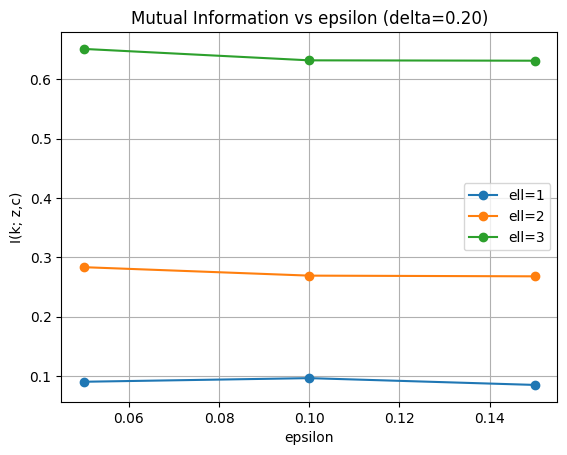

In [99]:
import matplotlib.pyplot as plt

# Example: I(k;z,c) vs epsilon for ell=1,2,3 at fixed delta=0.20
for ell in [1, 2, 3]:
    subset = df7.xs(key=(0.20, ell), level=('delta','ell'))
    plt.plot(subset.index, subset['I(kA;z,c)'], marker='o', label=f'ell={ell}')

plt.xlabel('epsilon')
plt.ylabel('I(k; z,c)')
plt.title('Mutual Information vs epsilon (delta=0.20)')
plt.legend()
plt.grid(True)
plt.show()